In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("task1_data.txt")
train_labels = pd.read_csv("task1_train_label.txt", header=None, sep="\t", names=["order", "label"])
valid_labels = pd.read_csv("task1_valid_label.txt", header=None, sep="\t", names=["order", "label"])
test_query = pd.read_csv("task1_test_query.txt",header=None, names=["order"])

In [3]:
train_df_original = df.merge(train_labels, on="order")
valid_df_original = df.merge(valid_labels, on="order")
test_df_original = df.merge(test_query, on="order")

In [4]:
train_df = train_df_original.copy()
valid_df = valid_df_original.copy()
test_df = test_df_original.copy()

# Matrix factorization

In [27]:
from scipy.sparse import coo_matrix

def create_interaction_matrix(df):
    labels = df["label"]
    rows = df["order"].factorize()[0]
    cols = df["product"].values
    n_user, n_item = df["order"].nunique(), df["product"].max()
    return coo_matrix((labels, (rows, cols)), shape=(n_user+1, n_item+1))

R_TR = create_interaction_matrix(train_df)

In [28]:
from sklearn.decomposition import NMF
N = 12
model = NMF(n_components=N, max_iter=1000, init='nndsvda').fit(R_TR)
U, V = model.transform(R_TR), model.components_

MF_cols = [f"MF_{i}" for i in range(N)]
product_stats_MF = pd.DataFrame(V.T, columns=MF_cols)

In [29]:
train_df_MF = train_df.merge(product_stats_MF, left_on="product", right_index=True, how="left")

In [30]:
order_features = train_df_MF.groupby("order")[MF_cols].sum().reset_index()
order_features = order_features.merge(train_labels, on="order")
order_features[MF_cols] = (order_features[MF_cols] - order_features[MF_cols].min()) / (order_features[MF_cols].max() - order_features[MF_cols].min())


In [56]:
pca = PCA(n_components=5)
pca.fit(order_features[MF_cols])
pca.explained_variance_ratio_
# order_features[MF_cols]

array([0.20768845, 0.17977684, 0.15317208, 0.12590693, 0.1118147 ])

In [59]:
from sklearn.linear_model import SGDClassifier
feature_names = MF_cols
features = order_features[feature_names]
labels = order_features["label"]
model = SGDClassifier()
model.fit(features, labels)
score = model.score(features, labels)

score

0.499851959019565

# Baseline

In [5]:
def create_return_df(df, labels, product_stats):
    df = df.merge(product_stats["return_rate"], how='left', right_index=True, left_on='product')
    df["no_return_rate"] = 1 - df["return_rate"]
    order_return_rate_prod = df.groupby('order')['return_rate'].prod()
    order_no_return_rate_prod = df.groupby('order')['no_return_rate'].prod()
    order_return_rate_sum = df.groupby('order')['return_rate'].sum()
    order_no_return_rate_sum = df.groupby('order')['no_return_rate'].sum()
    order_return_rate_mean = df.groupby('order')['return_rate'].mean()
    order_no_return_rate_mean = df.groupby('order')['no_return_rate'].mean()
    return_df = pd.concat([order_return_rate_prod, order_no_return_rate_prod,order_return_rate_sum,order_no_return_rate_sum,order_return_rate_mean,order_no_return_rate_mean], axis=1,
                          keys=["order_return_rate_prod", "order_no_return_rate_prod","order_return_rate_sum","order_no_return_rate_sum","order_return_rate_mean","order_no_return_rate_mean"])
    return_df["some_return"] = 1 - return_df["order_no_return_rate_prod"] - return_df["order_no_return_rate_prod"]
    return_df = return_df.merge(labels, on="order")
    return return_df

<Axes: >

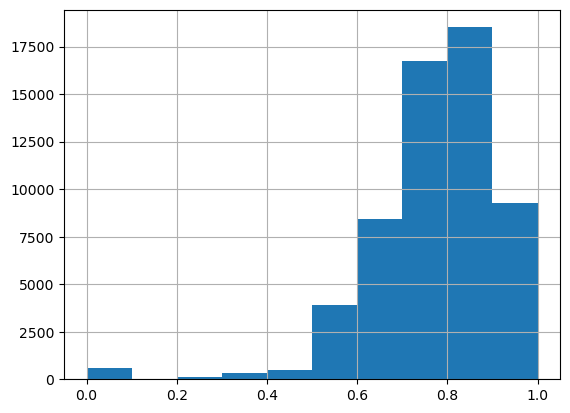

In [6]:
# Calculate how many times each product has been in an order that was returned/partially returned
# Return probability is the ratio of returns/partial returns and all occurences of the product
product_stats = train_df.groupby('product').agg(
    total_count=('product', 'count'),
    return_1_or_2_count=('label', lambda x: (x==1).sum() + (x==2).sum())
).reset_index(drop=True)
product_stats['return_rate'] = product_stats['return_1_or_2_count'] / product_stats['total_count']
product_stats["return_rate"].hist()

In [43]:
train_return_df = create_return_df(train_df, train_labels, product_stats)
conditions = [
    (train_return_df['order_no_return_rate_prod'] > train_return_df['some_return']) & (train_return_df['order_no_return_rate_prod'] > train_return_df['order_return_rate_prod']),
    (train_return_df['some_return'] > train_return_df['order_no_return_rate_prod']) & (train_return_df['some_return'] > train_return_df['order_return_rate_prod']),
    (train_return_df['order_return_rate_prod'] > train_return_df['order_no_return_rate_prod']) & (train_return_df['order_return_rate_prod'] > train_return_df['some_return'])
]

choices = [0, 1, 2]

train_return_df['prediction'] = np.select(conditions, choices, default=np.nan)

# Accuracy calculation
train_return_df["correct"] = train_return_df["prediction"] == train_return_df["label"]
accuracy = train_return_df["correct"].sum() / train_return_df["correct"].count()
accuracy

0.4909644533418569

In [7]:
import numpy as np

valid_return_df = create_return_df(valid_df, valid_labels, product_stats) # Prediction is the highest of the three probabilities
conditions = [
    (valid_return_df['order_no_return_rate_prod'] > valid_return_df['some_return']) & (valid_return_df['order_no_return_rate_prod'] > valid_return_df['order_return_rate_prod']),
    (valid_return_df['some_return'] > valid_return_df['order_no_return_rate_prod']) & (valid_return_df['some_return'] > valid_return_df['order_return_rate_prod']),
    (valid_return_df['order_return_rate_prod'] > valid_return_df['order_no_return_rate_prod']) & (valid_return_df['order_return_rate_prod'] > valid_return_df['some_return'])
]

choices = [0, 1, 2]

valid_return_df['prediction'] = np.select(conditions, choices, default=np.nan)

In [9]:
# Accuracy calculation
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

0.4837843566734968

In [10]:
def train_model(model, df ,feature_cols, label_col = "label"):
    features = df[feature_cols]
    labels = df[label_col]
    model.fit(features, labels)
    score = model.score(features, labels)
    return model, score
    
def validate_model(model, validation_df, feature_cols, label_col = "label"):
    features = validation_df[feature_cols]
    labels = validation_df[label_col]
    score = model.score(features, labels)
    return score

# Baseline - Simple model

In [11]:
train_return_df = create_return_df(train_df, train_labels, product_stats)
valid_return_df = create_return_df(valid_df, valid_labels, product_stats)

In [12]:
from sklearn.linear_model import SGDClassifier
feature_names = ["order_return_rate_prod", "order_no_return_rate_prod"]

features = train_return_df[feature_names]
labels = train_return_df["label"]
model = SGDClassifier()
model.fit(features, labels)
score = model.score(features, labels)

score

0.6056356509597429

In [13]:
valid_return_df["prediction"] = model.predict(valid_return_df[feature_names])
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

0.5817926313227663

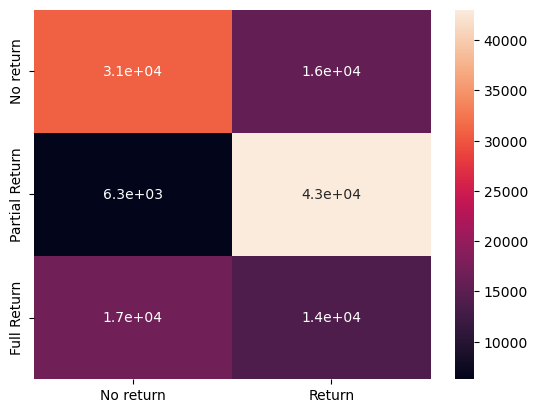

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(valid_return_df["label"], valid_return_df["prediction"])
cm[:,:2]
sns.heatmap(cm[:,:2], annot=True, yticklabels=["No return", "Partial Return", "Full Return"], xticklabels=["No return", "Return"])
plt.show()

In [22]:
cm

array([[30802, 15655,   430],
       [ 6261, 43034,    52],
       [17022, 13850,   271]])

# Use user return rate

In [16]:
# Create user return stats
customer_stats = train_df.groupby('customer').agg(
    total_count=('customer', 'count'),
    partial_return=('label', lambda x: (x==1).sum()),
    total_return = ('label', lambda x: (x==2).sum()),
).reset_index(drop=True)
customer_stats["no_return"] = customer_stats["total_count"] - customer_stats["partial_return"] - customer_stats["total_return"]

customer_stats["partial_return_rate"] = customer_stats["partial_return"] / customer_stats["total_count"]
customer_stats["total_return_rate"] = customer_stats["total_return"] / customer_stats["total_count"]
customer_stats["no_return_rate"] = customer_stats["no_return"] / customer_stats["total_count"]

In [ ]:
# Merge stats on the return dataframes
train_order_customer = train_df.groupby('order')['customer'].first().reset_index()
valid_order_customer = valid_df.groupby('order')['customer'].first().reset_index()

train_return_df = train_return_df.merge(train_order_customer, on="order")
train_return_df = train_return_df.merge(customer_stats[["no_return_rate", "partial_return_rate", "total_return_rate"]].add_prefix("customer_"), left_on="customer", right_index=True)

valid_return_df = valid_return_df.merge(valid_order_customer, on="order")
valid_return_df = valid_return_df.merge(customer_stats[["no_return_rate", "partial_return_rate", "total_return_rate"]].add_prefix("customer_"), left_on="customer", right_index=True)

In [ ]:
from sklearn.linear_model import SGDClassifier
feature_names = ["order_return_rate", "order_no_return_rate", "some_return", "customer_no_return_rate", "customer_partial_return_rate", "customer_total_return_rate"]
features = train_return_df[feature_names]
labels = train_return_df["label"]
model = SGDClassifier()
model.fit(features, labels)
score = model.score(features, labels)
score

In [ ]:
valid_return_df["prediction"] = model.predict(valid_return_df[feature_names])
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

# Use item group info

In [ ]:
train_df

In [ ]:
train_counts = train_df.groupby(['order', 'group']).size()
valid_counts = valid_df.groupby(['order', 'group']).size()

In [ ]:
train_order_size = train_df.groupby('order').size()
valid_order_size = valid_df.groupby('order').size()

train_normalized_counts = train_counts / train_order_size.loc[train_counts.index.get_level_values('order')].values
valid_normalized_counts = valid_counts / valid_order_size.loc[valid_counts.index.get_level_values('order')].values

In [ ]:
train_normalized_counts

In [ ]:
train_normalized_pivot = train_normalized_counts.unstack(fill_value=0)
valid_normalized_pivot = valid_normalized_counts.unstack(fill_value=0)

In [ ]:
if len(valid_normalized_pivot.columns) != len(train_normalized_pivot.columns):
    missing_cols = set(train_normalized_pivot.columns) - set(valid_normalized_pivot.columns)
    valid_normalized_pivot[list(missing_cols)] = 0

In [ ]:
train_return_df = create_return_df(train_df, train_labels, product_stats)
valid_return_df = create_return_df(valid_df, valid_labels, product_stats)

In [ ]:
train_return_df

In [ ]:
train_return_df = train_return_df.merge(train_normalized_pivot.add_prefix("group_"), left_on='order', right_index=True)
valid_return_df = valid_return_df.merge(valid_normalized_pivot.add_prefix("group_"), left_on='order', right_index=True)

In [ ]:
train_return_df

In [ ]:
feature_names = ["order_return_rate", "order_no_return_rate", "some_return"] + [f"group_{i}" for i in range(32)]
features = train_return_df[feature_names]
labels = train_return_df["label"]
model = SGDClassifier()
model.fit(features, labels)
score = model.score(features, labels)
score

In [ ]:
valid_return_df["prediction"] = model.predict(valid_return_df[feature_names])
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

# Use GNN embeddings

In [25]:
train_return_df = create_return_df(train_df, train_labels, product_stats)
valid_return_df = create_return_df(valid_df, valid_labels, product_stats)

train_embeddings = pd.DataFrame(np.load("train_node_embeddings.npy"))
valid_embeddings = pd.DataFrame(np.load("valid_node_embeddings.npy"))
train_return_df = train_return_df.merge(train_embeddings, left_on="order", right_index=True)
valid_return_df = valid_return_df.merge(valid_embeddings, left_on="order", right_index=True)

In [28]:
from sklearn.linear_model import SGDClassifier
feature_names = [0,1,2]
features = train_return_df[feature_names]
labels = train_return_df["label"]
model = SGDClassifier()
model.fit(features, labels)
score = model.score(features, labels)

score

0.31165921979928346

In [29]:
valid_return_df["prediction"] = model.predict(valid_return_df[feature_names])
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

0.3066161775533817

# Customer group size difference

In [23]:
def create_user_stat(df, group_by_cols, agg_col, agg_func):
    suff = "_"+"_".join(group_by_cols) + "_stat"
    agg_col_stat = agg_col + suff
    
    customer_stat =  df.groupby(group_by_cols).agg({agg_col: agg_func})
    merged_df = df.merge(customer_stat, on=group_by_cols, suffixes=("",suff))
    return merged_df

usual_user_size_by_group = train_df.groupby(['customer', 'group']).agg({"size": lambda x: pd.Series.mode(x)})

In [24]:
train_df = train_df.merge(usual_user_size_by_group, on=['customer', 'group'], suffixes=("","_customer_group_stat"))
train_df["size_diff"] = train_df["size"] - train_df["size_customer_group_stat"]

filter_single_mode = train_df[train_df["size_diff"].apply(lambda x: isinstance(x, np.int64))]
filter_multi_mode = train_df[train_df["size_diff"].apply(lambda x: not isinstance(x, np.int64))]

filter_multi_mode["size_diff"] = filter_multi_mode["size_diff"].apply(lambda x: min(abs(x)))

train_df.update(filter_multi_mode)
size_diff_agg_train =  train_df.groupby("order")["size_diff"].sum()

/tmp/ipykernel_1234803/759283014.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_multi_mode["size_diff"] = filter_multi_mode["size_diff"].apply(lambda x: min(abs(x)))


In [25]:
valid_df = valid_df.merge(usual_user_size_by_group, on=['customer', 'group'], suffixes=("","_customer_group_stat"))
valid_df["size_diff"] = valid_df["size"] - valid_df["size_customer_group_stat"]

filter_single_mode = valid_df[valid_df["size_diff"].apply(lambda x: isinstance(x, np.int64))]
filter_multi_mode = valid_df[valid_df["size_diff"].apply(lambda x: not isinstance(x, np.int64))]

filter_multi_mode["size_diff"] = filter_multi_mode["size_diff"].apply(lambda x: min(abs(x)))

valid_df.update(filter_multi_mode)
size_diff_agg_valid =  valid_df.groupby("order")["size_diff"].max()

/tmp/ipykernel_1234803/2601720739.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_multi_mode["size_diff"] = filter_multi_mode["size_diff"].apply(lambda x: min(abs(x)))


In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [26]:
train_return_df = create_return_df(train_df, train_labels, product_stats)
valid_return_df = create_return_df(valid_df, valid_labels, product_stats)

train_return_df = train_return_df.merge(size_diff_agg_train, on="order")
valid_return_df = valid_return_df.merge(size_diff_agg_valid, on="order")

In [30]:
std_scaler = MinMaxScaler()

to_transform_t = np.asarray(train_return_df["size_diff"]).reshape(-1, 1)
to_transform_v = np.asarray(valid_return_df["size_diff"]).reshape(-1, 1)
train_return_df["size_diff"] = std_scaler.fit_transform(to_transform_t)
valid_return_df["size_diff"] = std_scaler.transform(to_transform_v)

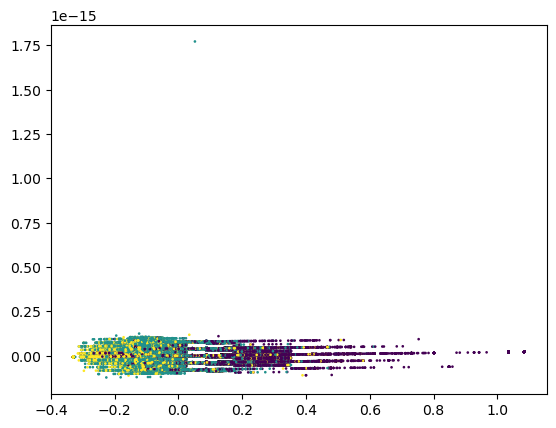

In [31]:
pca = PCA(n_components = 2)
res = pca.fit_transform(train_return_df[["order_return_rate_mean", "order_no_return_rate_mean"]])
plt.scatter(res[:,0], res[:,1], c=train_return_df["label"], s = 0.8)
plt.show()

In [32]:
from sklearn.svm import SVC
feature_names = ["order_return_rate_prod", "order_no_return_rate_prod","order_return_rate_sum","order_no_return_rate_sum","order_return_rate_mean","order_no_return_rate_mean"]
features = train_return_df[feature_names]
labels = train_return_df["label"]
model = RandomForestClassifier(verbose = 1)
model.fit(features, labels)
score = model.score(features, labels)
# accuracy = 0
accuracy = model.score(valid_return_df[feature_names], valid_return_df["label"])

print(f"Train score: {score} - Valid accuracy: {accuracy}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train score: 0.8464798210049964 - Valid accuracy: 0.5140296611339722


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished


In [33]:
model.feature_importances_

array([0.1612484 , 0.2205748 , 0.22400343, 0.14771028, 0.12444808,
       0.12201502])

In [34]:
import matplotlib.pyplot as plt

preds = model.predict(features)
correct = preds == labels

incorrect_df = features[~correct]
incorrect_labels = labels[~correct]

correct_df = features[correct]
correct_labels = labels[correct]




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.3s finished


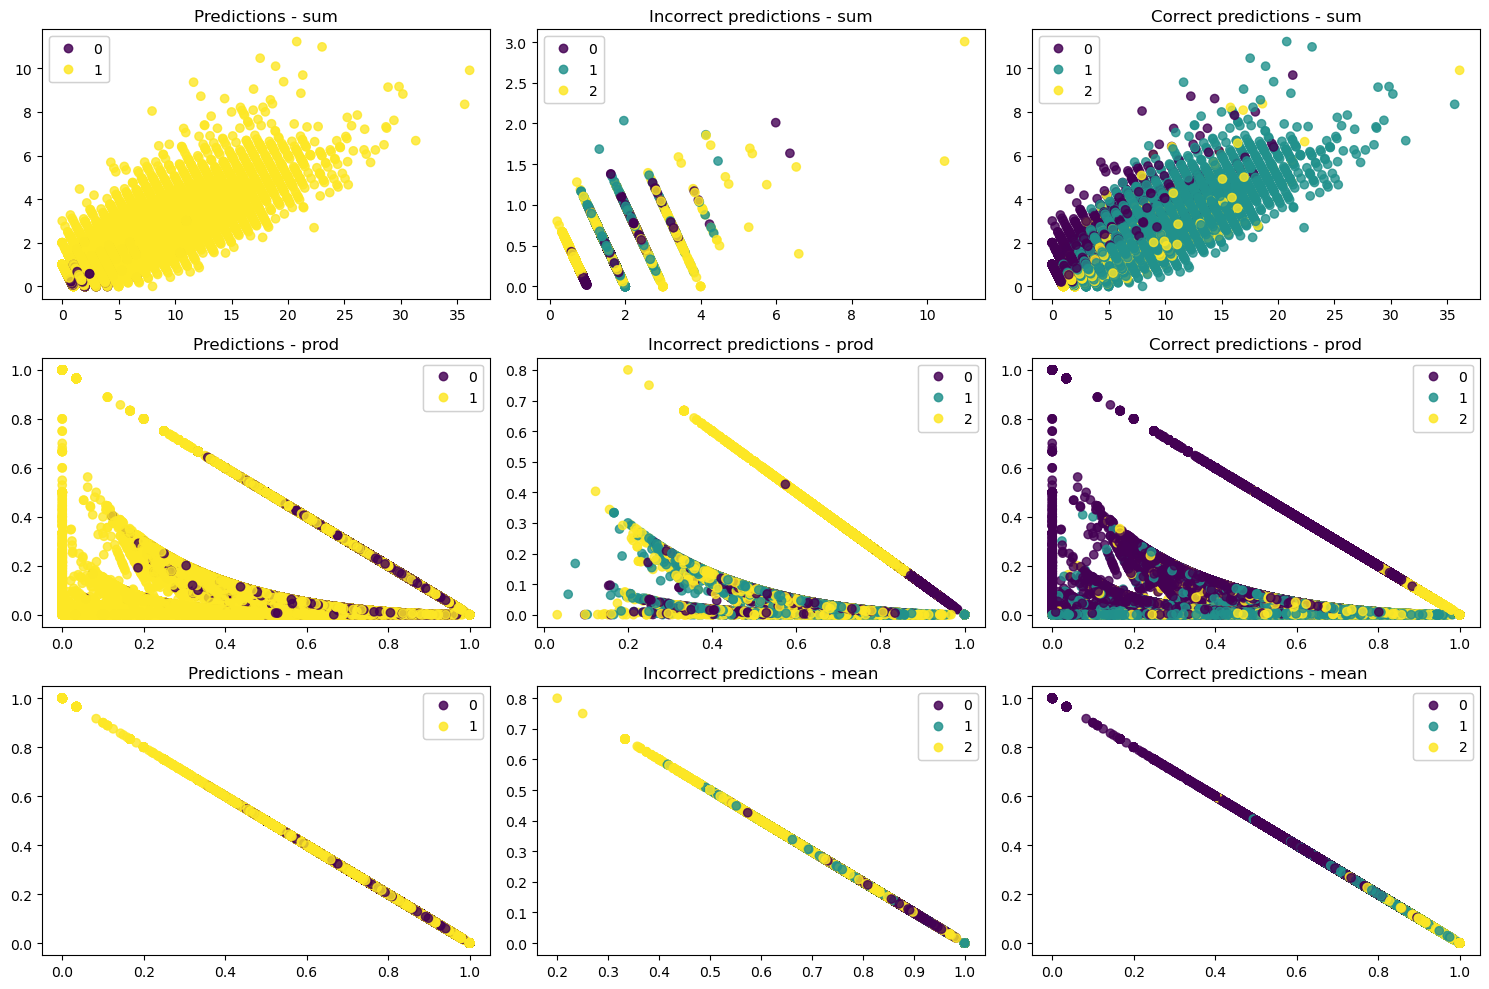

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for ax, aggr in zip(axs,["sum", "prod", "mean"]):
    for a, df, col, title in zip(ax, [train_return_df,incorrect_df,correct_df],[correct, incorrect_labels, correct_labels], ["Predictions", "Incorrect predictions", "Correct predictions"]):
        scatter = a.scatter(df["order_return_rate_" + aggr], df["order_no_return_rate_" + aggr], c=col, alpha = 0.8)
        legend1 = a.legend(*scatter.legend_elements())
        a.add_artist(legend1)
        a.set_title(title + " - " + aggr)
        
plt.tight_layout()
plt.show()

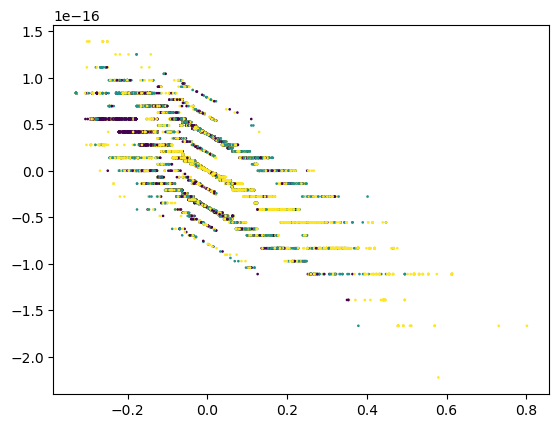

In [42]:
pca = PCA(n_components = 2)
pca.fit(train_return_df[["order_return_rate_mean", "order_no_return_rate_mean"]])
res = pca.transform(incorrect_df[["order_return_rate_mean", "order_no_return_rate_mean"]])
plt.scatter(res[:,0], res[:,1], c=incorrect_labels, s = 0.8)
plt.show()

In [49]:
accs_t = [0.490964,0.605635, 0.846479, 0.9536446]
accs_v = [0.48378435,0.581792,0.51402,0.334715]

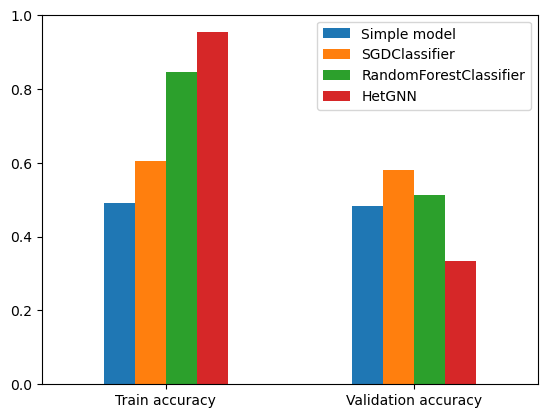

In [56]:
acc_df = pd.DataFrame({"Train accuracy": accs_t, "Validation accuracy": accs_v})
ax = acc_df.T.plot(kind="bar", rot=0)
ax.legend(["Simple model", "SGDClassifier", "RandomForestClassifier", "HetGNN"])
plt.show()